## Normal Vs. Anomaly

In this study case we illustrate a typical application for anomaly detection in a factory, using a custom toy dataset. We will show a quick implementation of a Convolutional Neural Network (CNN) made of 3 layers followed by a fully connected (FC) layer to carry out binary classification for anomaly detection. For this, we will use the PyTorch (https://pytorch.org/) Deep Learning Framework.


Our toy dataset consists of photographs of a yellow toy car from a top view. For this example, we consider an anomaly if the car has one, or both of its doors open, as shown in the figure below.

Here we import all the required libraries

In [1]:
# The following libraries are commonly used libraries in ML projects
import numpy as np                 # To handle multidimendional arrays
import pandas as pd                # Fundamental Data Science library that adds Numpy functionalities
import matplotlib.pyplot as plt    # To plot
import seaborn as sns              # Another plotting library
import os                          # Library that allows us Operative System functionalities
import os.path
%matplotlib inline
# PyTorch stuff
import torch                       # Fundamental PyTorch library
from torch import optim, nn        # Optimization and Neural Networks modules
from torch.nn import functional as F    # Fundamental functions for Deep Learning
from torchvision import transforms as T # To carry out transformation, basic for online data augmentation
from torchvision import datasets    # Import datasets that allows us to convert our data into PyTorch dataset objects
from torch.utils.data import DataLoader, Dataset, random_split   # To manipulate our datasets more easily
# To generate confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
# If you want to replicate this Notebook using Google Colab, please uncomment the following lines

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Let's get the data

The dataset we are going to use consist of 42 images, divided in 22 normal and 20 anomalies. The dataset in turn will be split randomly in training, validation and test sets, taking approximately 60% for the training set, 25% for the validation set and 15% for the test set.

<img src="cars3.png" alt="Alternative text" />for

In [4]:
# Please update datapath according to your location
# DATA_PATH =  '/media/pepe/DataUbuntu/Databases/DLpics'
DATA_PATH =  '/content/drive/My Drive/Colab Notebooks/Datasets/DLpics'
DEFECTIVE_PATH = DATA_PATH + '/defective'
NORMAL_PATH = DATA_PATH + '/normal'

### Let us create PyTorch Datasets and DataLoaders

### Transformations
We carry out some transformations to each of the images, to resize them to 224 x 224, as well as normalization. In this case, we use ImageNet statistics to carry out normalization per channel.

In [5]:
transforms = T.Compose([
                     T.Resize([224, 224]),
                     T.ToTensor(),
                     T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])

In [6]:
# if desired we can check the total number of images
TOTAL_SAMPLES = len(os.listdir(DEFECTIVE_PATH)) + len(os.listdir(NORMAL_PATH))
print(TOTAL_SAMPLES)

42


### Train, validation and test set

In [7]:
# I will further split into val and test
TRAIN_SIZE = int(0.6 * TOTAL_SAMPLES)
VAL_SIZE = int(0.25 * TOTAL_SAMPLES)
TEST_SIZE = TOTAL_SAMPLES - TRAIN_SIZE - VAL_SIZE
print(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)
BATCH_SIZE = 2
# Create the datasets using ImageFolder and random_split
full_dataset = datasets.ImageFolder(DATA_PATH, transform=transforms)
# From the full dataset, we randomly split it in train, validation and test set
# Notice that since we are not defining a random seed, replicating the experiments may lead to different
# splits in train, val and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

25 10 7


Create DataLoaders, that simplify iterating through the datasets

In [8]:
# create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Look at the data

La imagen muestreada representa un: normal


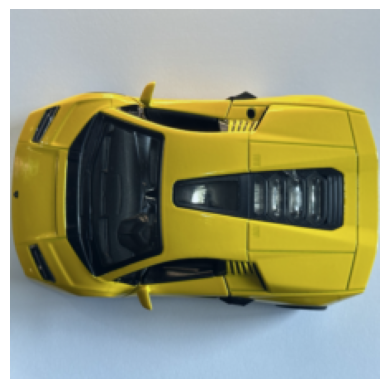

torch.Size([3, 224, 224])


In [9]:
classes = test_loader.dataset.dataset.classes

def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(train_loader))
print(f'La imagen muestreada representa un: {classes[train_loader.dataset[rnd_sample_idx][1]]}')
image = train_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)
print(image.shape)

### Accuracy Function

In [10]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader

    Returns:

    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
#             cost += (F.binary_cross_entropy_with_logits(torch.squeeze(scores), y.float())).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        return cost/len(loader), float(correct)/total

### Training loop

In [ ]:
def train(model, optimiser, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
#             cost = F.binary_cross_entropy_with_logits(input=torch.squeeze(scores), target=y.float())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num)/train_total
#             train_cost = train_cost_acum/mb
            val_cost, val_acc = accuracy(model, val_loader)

            val_loss_history.append(val_cost)
            train_loss_history.append(cost.item())
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)

            lrs.append(optimiser.param_groups[0]["lr"])


        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/len(train_loader)

        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

## Model

In this section we define our model, in this case it contains 3 convolutional layers, each with convolution kernels of size 3x3, stride 1, and padding 1, batch normalization and ReLU as activation function. The number of filters is 64, 128 and 128 for the first, second and third convolutional layers respectively. Finally, the last convolutional activation volume is flatten and a final Fully connected layer with two neurons (alternatively we could only use one neuron and consider binary cross entropy as cost function).

In [ ]:
model_CNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                           nn.BatchNorm2d(64),
                           nn.ReLU(),


                           nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                           nn.BatchNorm2d(128),
                           nn.ReLU(),
                           nn.MaxPool2d(2,2),


                           nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                           nn.BatchNorm2d(128),
                           nn.ReLU(),
                           nn.MaxPool2d(2,2),

                           nn.Flatten(),
                           nn.Linear(in_features=56*56*128, out_features=2)
                          )

finally, the model was trained using a constant learning rate of 0.00008 for 15 epochs, with mini batches of 2 images. The learning rate was found using random exploration, and the model was trained using the Adam optimizer.

In [ ]:
# Notice that since we are not defining a random seed, replicating the experiments may lead to different results
lr = 0.00008
epochs = 15
optimiser = torch.optim.Adam(model_CNN1.parameters(), lr)
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_CNN1,
                                optimiser=optimiser,
                                epochs = epochs
                                )

Epoch:0, train cost: 4.006452, val cost: 1.732712, train acc: 0.6400, val acc: 0.600000
Epoch:1, train cost: 5.565441, val cost: 0.127389, train acc: 0.6400, val acc: 1.000000
Epoch:2, train cost: 2.766708, val cost: 17.920629, train acc: 0.8000, val acc: 0.400000
Epoch:3, train cost: 6.142485, val cost: 0.000030, train acc: 0.6800, val acc: 1.000000
Epoch:4, train cost: 0.191450, val cost: 0.140018, train acc: 0.9600, val acc: 0.900000
Epoch:5, train cost: 0.147032, val cost: 0.004324, train acc: 0.9600, val acc: 1.000000
Epoch:6, train cost: 0.136917, val cost: 0.147939, train acc: 0.9600, val acc: 0.900000
Epoch:7, train cost: 0.072219, val cost: 0.000196, train acc: 0.9600, val acc: 1.000000
Epoch:8, train cost: 0.047289, val cost: 0.000139, train acc: 0.9600, val acc: 1.000000
Epoch:9, train cost: 0.014348, val cost: 0.000017, train acc: 1.0000, val acc: 1.000000
Epoch:10, train cost: 0.000001, val cost: 0.000000, train acc: 1.0000, val acc: 1.000000
Epoch:11, train cost: 0.000000

In [ ]:
# Notice that since we are not defining a random seed, replicating the experiments may lead to different results
accuracy(model_CNN1, test_loader)

(0.032402145303635166, 1.0)

## Make predictions from test set

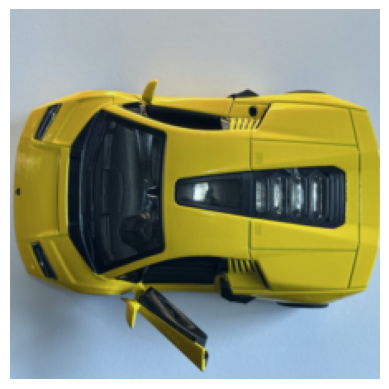

Predicted: defective
True: defective


In [22]:
classes = test_loader.dataset.dataset.classes
images, labels = next(iter(test_loader))
x = images[0].unsqueeze(0)
y = labels[0]
image = x.cpu()
model_CNN1.eval()
with torch.no_grad():
  x = x.to(device=device)
  y_hat = model_CNN1(x)
  _, pred = y_hat.max(dim=1)
  pred = pred.item()

image = (image - image.min()) / (image.max() -image.min() )
# Display the image
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.axis('off')
plt.show()

# Convert the labels to class names and print the result
print("Predicted:", classes[pred])
print("True:", classes[y])

### Create confusion matrix

In [ ]:
def confusion_mat(loader):

  # Initialize lists to store the true and predicted labels
  y = []
  predictions = []

  # Iterate over the test set
  model_CNN1.eval()
  with torch.no_grad():
      for images, labels in loader:
          if torch.cuda.is_available():
              images = images.to(device=device)
              labels = labels.to(device=device)
          outputs = model_CNN1(images)
          _, preds = torch.max(outputs.data, 1)

          y.extend(labels.cpu().numpy())
          predictions.extend(preds.cpu().numpy())

  # Generate the confusion matrix
  cm = confusion_matrix(y, predictions)
  # Let us see the confusion matrix
  # Define the labels of your classes
  classes = ["Normal", "Defective"]
  plt.figure(figsize=(10, 7))
  # Create a heatmap with seaborn
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  # Add labels to the plot
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  # Print the confusion matrix
  print(cm)
  return cm


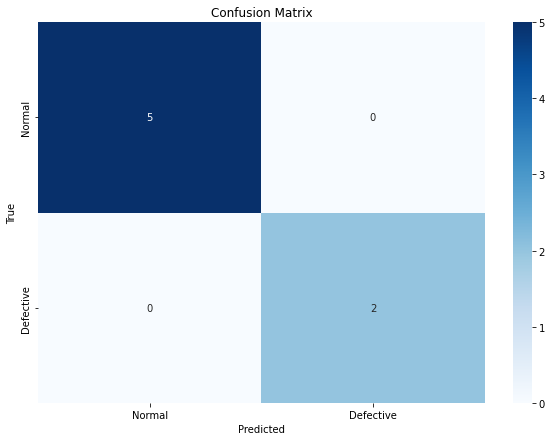

[[5 0]
 [0 2]]


In [ ]:
# Notice that since we are not defining a random seed, replicating the experiments may lead to different results
cm_test = confusion_mat(test_loader)

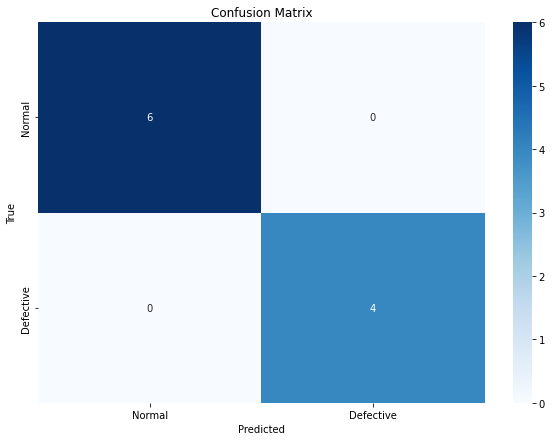

[[6 0]
 [0 4]]


In [ ]:
# Notice that since we are not defining a random seed, replicating the experiments may lead to different results
cm_val = confusion_mat(val_loader)

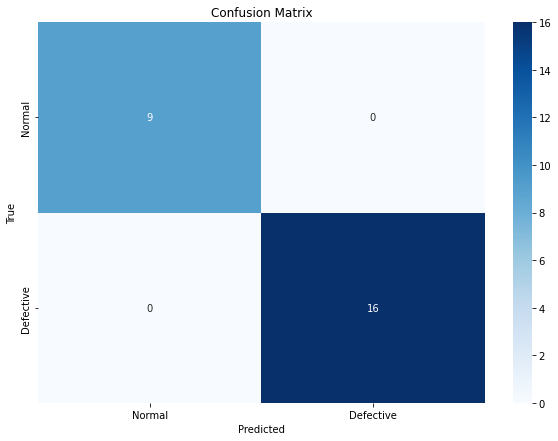

[[ 9  0]
 [ 0 16]]


In [ ]:
# Notice that since we are not defining a random seed, replicating the experiments may lead to different results
cm_train = confusion_mat(train_loader)

### To save a model

In [ ]:
#saving model
MODEL_PATH = '/media/pepe/DataUbuntu/github_repos/jacantoral/bookQ4/models/model_CNN1_balanced_224_100acc.pth'
# torch.save(model_CNN1.state_dict(), MODEL_PATH)

## To load a model

In [11]:
#to load model
model_CNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                           nn.BatchNorm2d(64),
                           nn.ReLU(),


                           nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                           nn.BatchNorm2d(128),
                           nn.ReLU(),
                           nn.MaxPool2d(2,2),


                           nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                           nn.BatchNorm2d(128),
                           nn.ReLU(),
                           nn.MaxPool2d(2,2),

                           nn.Flatten(),
                           nn.Linear(in_features=56*56*128, out_features=2)
                          )


# MODEL_PATH = '/media/pepe/DataUbuntu/github_repos/jacantoral/bookQ4/models/model_CNN1_balanced_224_100acc.pth'
MODEL_PATH ='/content/drive/My Drive/Colab Notebooks/models/model_CNN1_balanced_224_100acc.pth'
# model_CNN1.load_state_dict(torch.load(MODEL_PATH))
model_CNN1.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
model_CNN1 = model_CNN1.to(device=device)

## Never unseen new images

In [19]:
# Now to try with more images that are not even part of the test set
ADDITIONAL = 'more_defective'
MORE_DEFECTIVE = '/content/drive/My Drive/Colab Notebooks/Datasets/' + ADDITIONAL

additional_dataset = datasets.ImageFolder(MORE_DEFECTIVE, transform=transforms)
more_test_loader = DataLoader(additional_dataset, batch_size=5, shuffle=True)


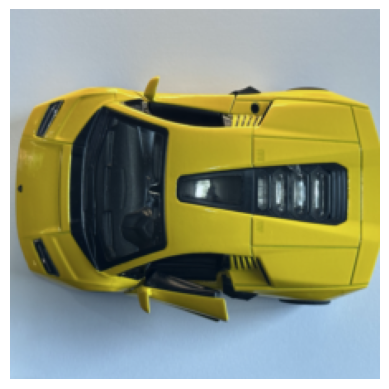

Predicted: defective
True: defective


In [28]:
images, labels = next(iter(more_test_loader))
x = images[0].unsqueeze(0)
y = labels[0]
image = x.cpu()
model_CNN1.eval()
with torch.no_grad():
  x = x.to(device=device)
  y_hat = model_CNN1(x)
  _, pred = y_hat.max(dim=1)
  pred = pred.item()

image = (image - image.min()) / (image.max() -image.min() )
# Display the image
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.axis('off')
plt.show()

# Convert the labels to class names and print the result
print("Predicted:", classes[pred])
print("True:", classes[y])

# len(additional_dataset)